# Quadratic RF Spoiling bSSFP #

In [1]:
import numpy as np
import math
import random
import matplotlib.pyplot as plt
from scipy.fft import fft
from scipy.optimize import curve_fit

import pandas as pd
import openpyxl

In [2]:
import sys
from matplotlib import pyplot as plt
import numpy as np
import sys
sys.path.insert(1, '../../../mri_sim')
sys.path.insert(1, '../../..')

sys.path.insert(0, '../../../mri_sim/SSFP')
from simulator import *

# Functions
### Quadratic Phase

In [3]:
#Calculate the phase shift for current TR (quadratic spoiling)
def QuadraticPhase(N, n):
    n = n%N
    phi_quad = 360/N
    phase = phi_quad*n*n/2
 
    #in degree
    return phase


<p>Parameters T1, T2, TR, TE, tip angle, period, initial magnetisation. <p/>


### Quadratic RF spoiling bSSFP - data simulation function
### with Noise and Field inhomogeneous

In [4]:
#Simulate Data with different field inhomogeneous effect (different T2*) and random noise 
def quadratic_RFspoiling_bSSFP (T1, T2, off_res_max, TR, TE, tip_angle, Period, M0, TRnum, M_transverse, off_resonance_f, T2p, testnum, AddNoise, Noise):
    
    SimulatedData = np.asarray(np.zeros((1,testnum,off_resonance_f.shape[0])), dtype = float) #Array with (T2*num, noise num, off-res f num)
    T2Star_GT = np.asarray([], dtype = float) #Store the Ground Truth T2*
    #simulate basic off-resonance profile
    #M_transverse, off_resonance_f = basic_quadratic_RFspoiling_bSSFP(T1, T2, off_res_max, TR, TE, tip_angle, Period, M0, 1, TRnum)
    
    #Add field inhomogeneous 
    for T2_inhom in T2p:
        SimulatedData_slice = np.asarray(np.zeros((1,off_resonance_f.shape[0])), dtype = float)
        #Store Ground truth T2*------------------------------------
        T2Star_GT = np.append(T2Star_GT, 1/((1/T2)+(1/T2_inhom)))
        
        #Add inhomogeneous, get the off-resonance profile with inhomogeneous effect added
        M_transverse_inhomo = AddfieldInhomogeneous(M_transverse, TR, TE, T2_inhom, off_resonance_f)
        
        #Add Noise
        for test in range (0, testnum ):
            if (AddNoise == True):
                M_transverse_inhomo_noise = M_transverse_inhomo + Noise[test,:]
            else:
                M_transverse_inhomo_noise = M_transverse_inhomo
            SimulatedData_slice = np.append(SimulatedData_slice, M_transverse_inhomo_noise.reshape(1,off_resonance_f.shape[0]), axis = 0)
        SimulatedData_slice = np.delete(SimulatedData_slice,0,0)
        SimulatedData = np.append(SimulatedData, SimulatedData_slice.reshape(1,testnum,off_resonance_f.shape[0]), axis = 0)
    SimulatedData = np.delete(SimulatedData,0,0)
        
#         #______________________T2* Fit________TESTING______________________________
#         F_state_magnitude, F_state = Fstate (M_transverse_noise)
        
#         F_state = np.round(F_state).astype(int) #round F-state all to integer 
#         F = np.asarray([], dtype = float)
#         F_Magnitude = np.asarray([], dtype = float)
#         for i in range (0,6):
#             F_index = np.where(F_state == float(-1-2*i))

#             F = np.append(F, i)
#             F_Magnitude = np.append(F_Magnitude, np.abs(F_state_magnitude[F_index]))
            
#         #End

#         ## time = TE+F*TR
#         time = TE*np.ones(np.shape(F))+ F *TR
        
#         def func(t, A, R2Star):
#             return A * np.exp(-R2Star * t)
#         #fitted coefficient stored in popt:[A R2*] --> T2* = 1/R2*
#         popt, pcov = curve_fit(func, time, F_Magnitude)
        
#         plt.figure(1)
#         plt.plot(time, F_Magnitude)
#         T2Star_measured = 1/popt[1]
#         print(T2Star_GT)
#         print(T2Star_measured)
#         #______________________________TESTING______________________________
        
    #Reshape into 3D Array(T2*num, noise num, off-res f num)    
    #SimulatedData = SimulatedData.reshape(np.shape(T2p)[0], testnum, np.shape(M_transverse_inhomo_noise)[-1])   
        
    return SimulatedData, T2Star_GT

In [5]:
#Off-resonance profile magnitude --> F-state magnitude 
def Fstate(M_transverse):
    F_Magnitude = np.fft.fftshift(M_transverse)
    F_Magnitude = np.fft.fft(F_Magnitude)/M_transverse.shape[-1]
    F_Magnitude = np.fft.ifftshift(F_Magnitude)
    

    F_state = np.fft.fftfreq(M_transverse.shape[-1], d = 1.0)
    F_state = np.fft.fftshift(F_state)*M_transverse.shape[-1]
    
    return F_Magnitude, F_state


#plot off resonance profile and F-state profile for multiple data acquisition 
#dataAcquire: number of profile
#off_resonance_f (n,) || M_transverse (dataAcquire, n)
def Offres_Fstate_plot(off_resonance_f, M_transverse, dataAcquire, Period, Fmin, Fmax):
    F_Magnitude, F_state = Fstate(M_transverse)
                                            
            
        
#     #Fourier transform of the off-resonance profile --> contribution from each F-state
#     S_F = np.fft.fft(M_transverse)/np.shape(np.squeeze(M_transverse))[0]
#     S_F = np.absolute(S_F)
#     S_F = np.fft.fftshift(S_F)

#     F_state = np.fft.fftfreq(M_transverse.shape[-1], d = 1.0)
#     F_state = np.fft.fftshift(F_state)*M_transverse.shape[-1]
    

    fig, axs  = plt.subplots(dataAcquire,2,figsize=(15, 5))
    if (dataAcquire == 1):
        axs[0].set_title("off-resonance profile")
        axs[1].set_title("Fstate of " + str(Period)+ " period")

        axs[0].plot(off_resonance_f, np.absolute(M_transverse[0,:]))
        axs[0].set_xlabel("off resonance frequency (Hz)")
        axs[0].set_ylabel("$|M_{xy}|$")

        axs[1].bar(F_state, np.absolute(F_Magnitude[0,:]))
        axs[1].set_xlim([Fmin,Fmax])
        axs[1].set_xlabel("F state")
        axs[1].set_ylabel("$F_Magnitude$")
    else:    
        axs[0,0].set_title("off-resonance profile")
        axs[0,1].set_title("Fstate of " + str(Period)+ " period")
        for i in range (0,dataAcquire):
            axs[i,0].plot(off_resonance_f, np.absolute(M_transverse[i,:]))
            axs[i,0].set_xlabel("off resonance frequency (Hz)")
            axs[i,0].set_ylabel("$|M_{xy}|$")



            axs[i,1].bar(F_state, np.absolute(F_Magnitude[i,:]))
            axs[i,1].set_xlim([Fmin,Fmax])
            axs[i,1].set_xlabel("F state")
            axs[i,1].set_ylabel("$F_Magnitude$")
    return fig, axs



<p>Add field inhomogeneous <p\>

In [6]:
#Add field inhomogeneous to model T2* effect (for F_number F-states, F_number = 6 --> 0,1,2...5 F-states
def AddfieldInhomogeneous(M_transverse, TR, TE, T2prime, off_resonance_f):
   
    #F-state
    F_state_magnitude, F_state = Fstate(M_transverse)
    F_state = np.round(F_state).astype(int) #round F-state all to integer 
    F_state_magnitude_inhomo = F_state_magnitude
    
    index = 0
    for i in F_state:
        #remove the empty state caused by taking 2 period off-res profile 
        if ((i%2) == 0):
            F = np.abs(-i//2) #the right F-state (all cast to positive)
            time = TE+ F *TR
            if (T2prime == 0):
                F_state_magnitude_inhomo[0,index] = F_state_magnitude[0,index]
            else:
                F_state_magnitude_inhomo[0,index] = F_state_magnitude[0,index] *np.exp(-time/T2prime)
        index = index + 1 
    #End
    
    #inverse fft get the off-res profile again
    M_transverse_inhomo = np.fft.ifftshift(F_state_magnitude_inhomo[0,:])
    M_transverse_inhomo = np.fft.ifft(M_transverse_inhomo)*np.shape(F_state_magnitude[0,:])[-1]
    M_transverse_inhomo = np.fft.fftshift(M_transverse_inhomo)
    
    #___________________________________Figure show the process_______________________________________________
    #fig_addinhomo, ax1 = plt.subplots(2, 2, figsize = (15,10))
    #Figure Off-res
    # ax1[0,0].plot(off_resonance_f, np.abs(M_transverse[0,:]))
    # ax1[0,0].set_ylim([0, 0.2])
    # ax1[0,0].set_xlabel("off-resonance frequency")
    # ax1[0,0].set_title("Original off-resonance profile")
    # #Figure F-state of original off-res profile
    # ax1[0,1].bar(F_state, np.abs(F_state_magnitude[0,:]))
    # ax1[0,1].set_xlim([-100,100])
    # ax1[0,1].set_xlabel("F-state")
    # ax1[0,1].set_title("Original F-state")
    # #Figure F-state after add inhomogeneous
    # ax1[1,1].bar(F_state, np.abs(F_state_magnitude_inhomo[0,:]))
    # ax1[1,1].set_xlim([-100,100])
    # ax1[1,1].set_xlabel("F-state")
    # ax1[1,1].set_title("F-state with inhomogeneous")
    # #Figure Off-res after add inhomogeneous
    # ax1[1,0].plot(off_resonance_f,np.abs(M_transverse_inhomo))
    # ax1[1,0].set_ylim([0, 0.2])
    # ax1[1,0].set_title("Off-resonance profile with inhomogeneous")
    # ax1[1,0].set_xlabel("off-resonance frequency")
    
    # plt.figure(1)
    # plt.plot(off_resonance_f,np.abs(M_transverse[0,:]))
    # plt.plot(off_resonance_f,np.abs(M_transverse_inhomo))
    # plt.title("Off-resonance profile with inhomogeneous")
    # plt.xlabel("off-resonance frequency")
    #plt.savefig("./Figure/noise/6Period_addinhomoProcess.jpg")
    return M_transverse_inhomo


### T2* value fit using simulated data

In [7]:
#Performing T2* Fit using the previous simulated data (F-state)
def T2StarFit(Data, T2Star_GT, Period, TR):
    #testnumber*(T2'number) matrix storing T2* ground truth and measured --> used to calculate error later 
    #each row store measured T2* value for a ground truth T2*
    TE = TR/2
    
    testnumber = np.shape(Data)[1]
    T2s_m_all = np.asarray([], dtype = float)
    #testnumber*2 matrix storing mean error and sd
    ErrorMean = np.asarray([], dtype = float)
    Errorstd = np.asarray([], dtype = float)
    Bias = np.asarray([], dtype = float)

    slicenum = 0 #slice from the dataset, each slice contain several simulated data for one T2*

    for GroundTruth in T2Star_GT:
        T2s_m = np.asarray([], dtype = float)
        for test in range (0,testnumber):
            #select each line from dataset 
            M_transverse_measured = Data[slicenum, test, :]

            #______________________T2* Fit______________________________________
            F_state_magnitude, F_state = Fstate (M_transverse_measured)

            #fit using 6 or less F-states
            F_state = np.round(F_state).astype(int) #round F-state all to integer 
            F = np.asarray([], dtype = float)
            F_Magnitude = np.asarray([], dtype = float)
            if (Period >=6):
                for i in range (0,6):
                    F_index = np.where(F_state == float(2+2*i))

                    F = np.append(F, i)
                    F_Magnitude = np.append(F_Magnitude, np.abs(F_state_magnitude[F_index]))

                #End
            else:
                for i in range (0,Period):
                    F_index = np.where(F_state == float(2+2*i))

                    F = np.append(F, i)
                    F_Magnitude = np.append(F_Magnitude, np.abs(F_state_magnitude[F_index]))

                #End

            ## time = TE+F*TR
            time = TE*np.ones(np.shape(F))+ F *TR

            def func(t, A, R2Star):
                return A * np.exp(-R2Star * t)
            #fitted coefficient stored in popt:[A R2*] --> T2* = 1/R2*
            popt, pcov = curve_fit(func, time, F_Magnitude)

            # plt.figure(1)
            # plt.plot(time, F_Magnitude, marker = 'o')
            T2Star_measured = 1/popt[1]
            T2s_m = np.append(T2s_m, T2Star_measured)
        
            #____________________________________________________________
        #For End

        #calculate error
        #T2s_m_all = np.append(T2s_m_all, T2s_m)
        #Error_test = np.square(T2s_m - GroundTruth)
        #Error_test = T2s_m - GroundTruth
        T2s_m_mean = np.mean(T2s_m)
        ErrorMean = np.append(ErrorMean, T2s_m_mean-GroundTruth)
        Errorstd = np.append(Errorstd, np.std(T2s_m))
        Bias = np.append(Bias, (T2s_m_mean-GroundTruth)/GroundTruth)
        slicenum = slicenum + 1
        
    #For End

    return ErrorMean, Errorstd, Bias
    #T2s_m_all = T2s_m_all.reshape(T2Star_GT.shape[-1], testnumber)

#plt.savefig("./Figure/noise/"+str(Period)+"Period_"+str(TR)+"_TR_T2StarFit.jpg")

# Simulation Parameters

In [9]:
# the parameters used in this simulation 
#time unit --- second
proton_density = 1.0
T1 = 900e-3
T2 = 44e-3
off_res_samplesize = 1000

TR = np.asarray([], dtype = float)
TR_min = 2e-3
TR_max = 10e-3
TR_n = 20
TR_increment = (TR_max-TR_min)/TR_n
for i in range (0, TR_n):
    TR = np.append(TR, TR_min+TR_increment*i)
    
TE = TR/2
#number of TR
Nr = 500
# tip angle alpha 10
tip_angle = 10
alpha = [np.deg2rad(tip_angle)] * Nr
#phase cycling
Period = 12
#initial magnetisation 
M0 = 1
#off resonance profile range
f = 4
off_res = np.linspace(-np.pi*f, np.pi*f, off_res_samplesize)

dphi = [0]* Nr
phi = []
for i in range (0,Nr):
    p = np.deg2rad(QuadraticPhase(Period,i))
    phi.append(p)
    
#T2* range 13 ms to 53 ms
T2s_min = 13
T2s_max = 53
T2p = np.asarray([], dtype = float)

for i in range (T2s_min, T2s_max):
    T2p = np.append(T2p, 1/((1000/i)-1/T2))
        
#number of simulation run
testnumber = 1000
AddNoise = True

# Simulate Data
<p>Bloch simulation<p/>

In [102]:
Noise = np.random.normal(0,0.01,(testnumber,off_res_samplesize)) + 1j*np.random.normal(0,0.01,(testnumber,off_res_samplesize))

In [103]:
ErrorMeanfigdata = np.asarray(np.zeros((1,np.shape(T2p)[0])), dtype = float)
Errorstdfigdata = np.asarray(np.zeros((1,np.shape(T2p)[0])), dtype = float)
Biasfigdata = np.asarray(np.zeros((1,np.shape(T2p)[0])), dtype = float)
#All_Data = np.asarray([], dtype = float) 
number = 0

for tr in TR:
    #Simulate Data
    #Generate bSSFP off-resonance profile using Bloch simulation 
    TR_list = [tr *1e3] * Nr 
    TE = tr/2

    off_resonance_f, M_transverse =  blochc(off_res, off_res_samplesize, M0 = M0 , alpha = alpha, phi = phi, dphi = dphi, TR= TR_list, TE= TE*1e3, T1 = T1*1e3, T2 = T2*1e3)
    off_resonance_f = off_resonance_f/2
    # plt.figure(2)
    # plt.plot(off_resonance_f, np.abs(M_transverse))
    
    #Add Field inhomogeneous and Noise
    #Data is an Array contain (T2*num, noise num, off-res f num)
    Data, T2Star_GT = quadratic_RFspoiling_bSSFP (T1, T2, int(1/tr), tr, tr/2, tip_angle, Period, M0, Nr, np.transpose(M_transverse), off_resonance_f, T2p, testnumber, AddNoise, Noise)
    
    
    np.save("TwelvePeriodData_"+str(tr)+"_0.01Noise.npy", Data)
    #Data = np.load("./DataNpy/SixPeriod_0.01/SixPeriodData_"+str(round(tr, 2-int(floor(log10(abs(tr))))-1))+"_.npy")
    #Fit T2*
    ErrorMean, Errorstd, Bias = T2StarFit(Data, T2Star_GT, Period, tr)
    #figurex = DrawT2StarGraph(Data, T2Star_GT, Period, tr)
    #Store data for the map
    ErrorMean = ErrorMean.reshape(1,np.shape(T2Star_GT)[0])
    Errorstd = Errorstd.reshape(1,np.shape(T2Star_GT)[0])
    Bias = Bias.reshape(1,np.shape(T2Star_GT)[0])
    ErrorMeanfigdata = np.append(ErrorMeanfigdata, ErrorMean, axis = 0)
    Errorstdfigdata = np.append(Errorstdfigdata, Errorstd, axis = 0)
    Biasfigdata = np.append(Biasfigdata, Bias, axis = 0)
    
    
    print(tr)
ErrorMeanfigdata = np.delete(ErrorMeanfigdata,0,0)
Errorstdfigdata = np.delete(Errorstdfigdata,0,0)
Biasfigdata = np.delete(Biasfigdata,0,0)

0.002
0.0024000000000000002
0.0028
0.0032
0.0036
0.004
0.0044
0.0048000000000000004
0.0052
0.005600000000000001
0.006
0.0064
0.0068000000000000005
0.007200000000000001
0.0076
0.008
0.008400000000000001
0.0088
0.0092
0.009600000000000001


In [104]:
np.save(str(Period)+"PeriodData_0.01Noise_ErrorMean.npy", ErrorMeanfigdata)
np.save(str(Period)+"PeriodData_0.01Noise_Errorstd.npy", Errorstdfigdata)
np.save(str(Period)+"PeriodData_0.01Noise_Bias.npy", Biasfigdata)

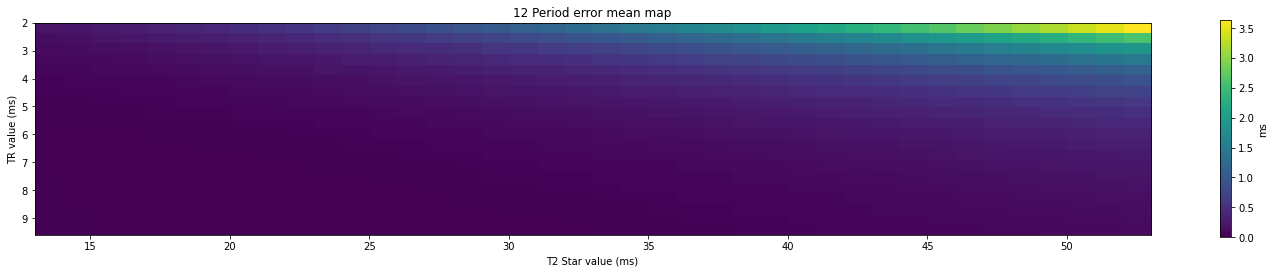

In [106]:
errormap, mapax = plt.subplots(figsize = (25,4))
errormap = mapax.imshow(ErrorMeanfigdata*1e3, extent=[T2s_min,T2s_max,TR[-1]*1000,TR[0]*1000])
c_map_m = plt.colorbar(errormap, ax = mapax)
c_map_m.set_label("ms")
mapax.set_xlabel("T2 Star value (ms)")
mapax.set_ylabel("TR value (ms)")
mapax.set_title(str(Period)+" Period error mean map")

#plt.savefig("./Figure/12Period_20TRs_1000NoiseWith0.01sd/"+str(Period)+"Period_TR_T2StarMeanErrorMap.jpg")
plt.show()
#plt

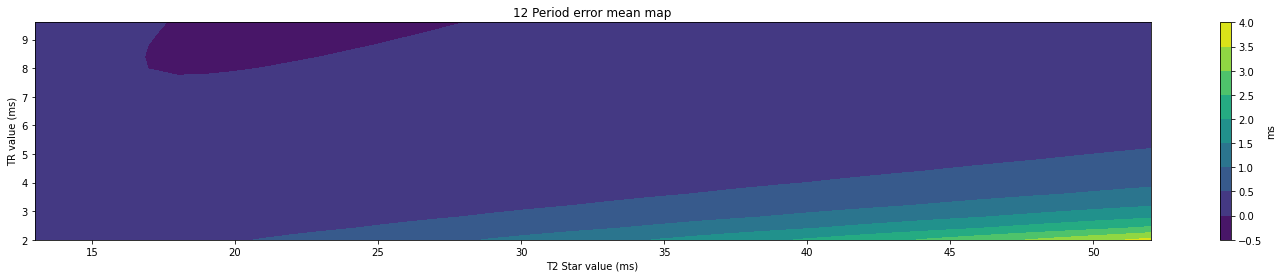

In [107]:
errormap, mapax = plt.subplots(figsize = (25,4))

contourImage = mapax.contourf(T2Star_GT*1e3,TR*1e3,ErrorMeanfigdata*1e3)
c_map_m = errormap.colorbar(contourImage, ax=mapax)
c_map_m.set_label("ms")

mapax.set_xlabel("T2 Star value (ms)")
mapax.set_ylabel("TR value (ms)")
mapax.set_title(str(Period)+" Period error mean map")
#plt.savefig("./Figure/12Period_20TRs_1000NoiseWith0.01sd/"+str(Period)+"Period_TR_T2StarMeanErrorMap_Contour.jpg")

In [12]:
Errorstdfigdata = np.load("./Figure/6Period_20TRs_1000NoiseWith0.01sd/NPY/6PeriodData_0.01Noise_ErrorMean.npy")

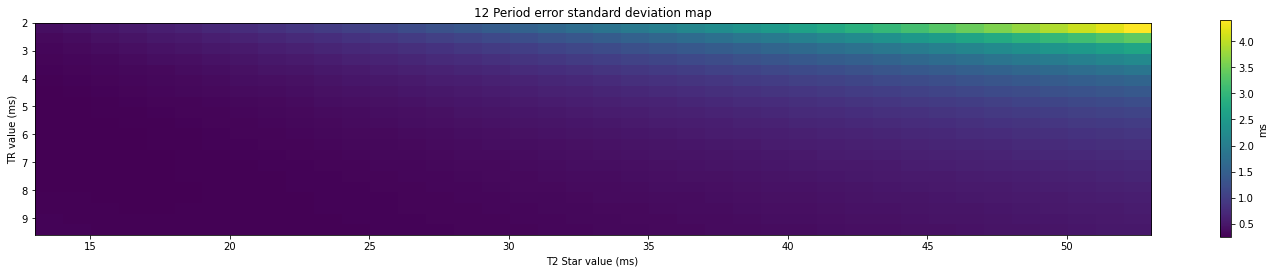

In [108]:
errorstdmap, std_mapax = plt.subplots(figsize = (25,4))
errorstdmap = std_mapax.imshow(Errorstdfigdata*1e3, extent=[T2s_min,T2s_max,TR[-1]*1000,TR[0]*1000])
c_bar_sd = plt.colorbar(errorstdmap, ax = std_mapax)
c_bar_sd.set_label("ms")
std_mapax.set_xlabel("T2 Star value (ms)")
std_mapax.set_ylabel("TR value (ms)")
std_mapax.set_title(str(Period)+" Period error standard deviation map")

#plt.savefig("./Figure/12Period_20TRs_1000NoiseWith0.01sd/"+str(Period)+"Period_TR_T2StarErrorSDMap.jpg")
plt.show()
#plt

Text(0.5, 1.0, '12 Period error standard deviation map')

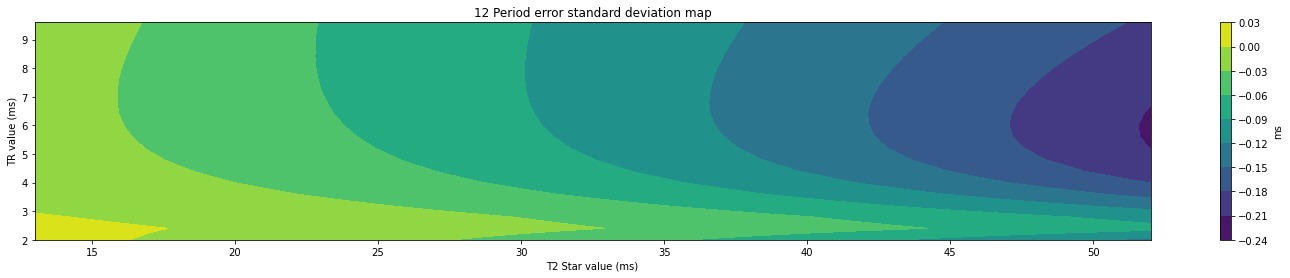

In [15]:
errorstdmap, std_mapax = plt.subplots(figsize = (25,4))

contourImage = std_mapax.contourf(T2Star_GT*1e3,TR*1e3,Errorstdfigdata*1e3)
c_bar_sd = errorstdmap.colorbar(contourImage, ax=std_mapax)
c_bar_sd.set_label("ms")

std_mapax.set_xlabel("T2 Star value (ms)")
std_mapax.set_ylabel("TR value (ms)")
std_mapax.set_title(str(Period)+" Period error standard deviation map")
#plt.savefig("./Figure/12Period_20TRs_1000NoiseWith0.01sd/"+str(Period)+"Period_TR_T2StarErrorSDMap_Contour.jpg")

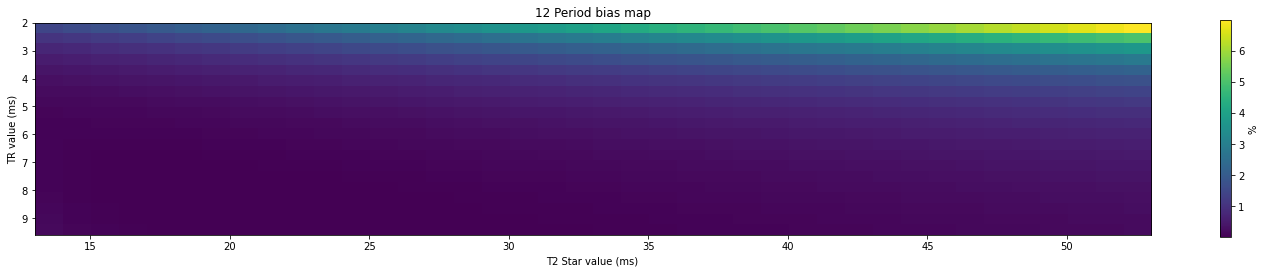

In [110]:
biasmap, bias_mapax = plt.subplots(figsize = (25,4))
biasmap = bias_mapax.imshow(np.abs(Biasfigdata)*100, extent=[T2s_min,T2s_max,TR[-1]*1000,TR[0]*1000])
c_bar_b = plt.colorbar(biasmap, ax = bias_mapax)
c_bar_b.set_label("%")
bias_mapax.set_xlabel("T2 Star value (ms)")
bias_mapax.set_ylabel("TR value (ms)")
bias_mapax.set_title(str(Period)+" Period bias map")

#plt.savefig("./Figure/12Period_20TRs_1000NoiseWith0.01sd/"+str(Period)+"Period_TR_T2StarBiasMap.jpg")
plt.show()
#plt

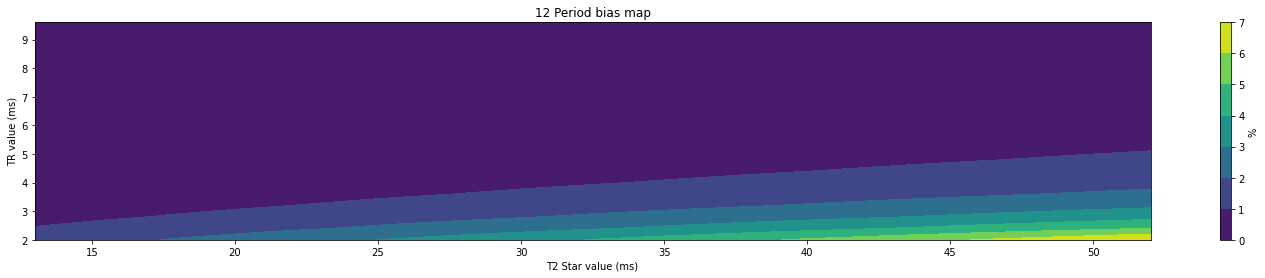

In [111]:
biasmap, bias_mapax = plt.subplots(figsize = (25,4))

contourImage = bias_mapax.contourf(T2Star_GT*1e3,TR*1e3,np.abs(Biasfigdata)*100)
c_bar_b = biasmap.colorbar(contourImage, ax=bias_mapax)
c_bar_b.set_label("%")
bias_mapax.set_xlabel("T2 Star value (ms)")
bias_mapax.set_ylabel("TR value (ms)")
bias_mapax.set_title(str(Period)+" Period bias map")
#plt.savefig("./Figure/12Period_20TRs_1000NoiseWith0.01sd/"+str(Period)+"Period_TR_T2StarBiasMap_Contour.jpg")

(-15.0, 15.0)

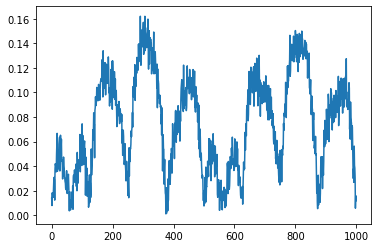

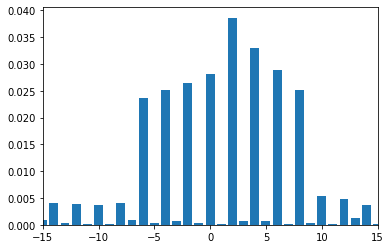

In [11]:
#View off-resonance profile 
d = np.load("./DataNpy/4Period_0.01/FourPeriodData_"+str(TR[0])+"_0.01Noise.npy")
np.shape(d)
plt.figure(1)
plt.plot(np.abs(d[1,1,:]))
Value, F = Fstate(d[1,1,:])
plt.figure(2)
plt.bar(F, np.abs(Value))
plt.xlim([-15,15])

(-15.0, 15.0)

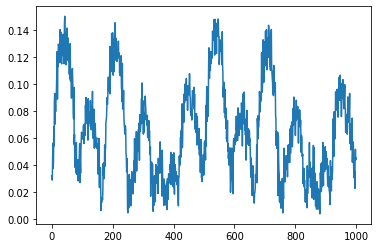

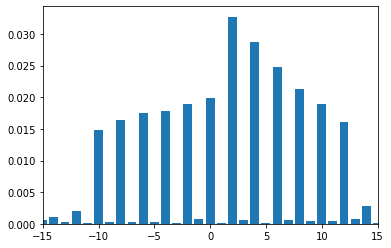

In [85]:
#View off-resonance profile 
d = np.load("./DataNpy/6Period_0.01/SixPeriodData_0.002_.npy")
np.shape(d)
plt.figure(1)
plt.plot(np.abs(d[1,1,:]))
Value, F = Fstate(d[1,1,:])
plt.figure(2)
plt.bar(F, np.abs(Value))
plt.xlim([-15,15])

(-15.0, 15.0)

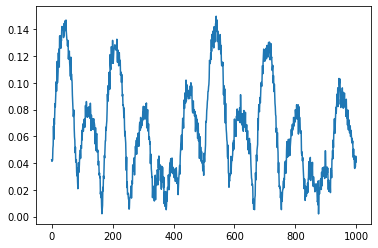

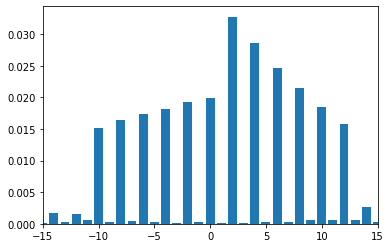

In [86]:
#View off-resonance profile 
d = np.load("./DataNpy/6Period_0.005/SixPeriodData_0.002_0.005Noise.npy")
np.shape(d)
plt.figure(1)
plt.plot(np.abs(d[1,1,:]))
Value, F = Fstate(d[1,1,:])
plt.figure(2)
plt.bar(F, np.abs(Value))
plt.xlim([-15,15])

(-20.0, 20.0)

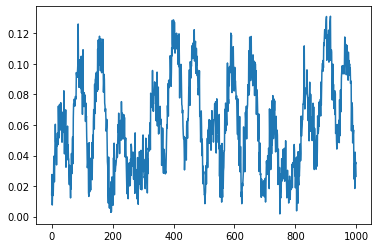

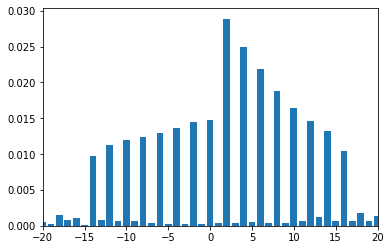

In [88]:
#View off-resonance profile 
d = np.load("./DataNpy/8Period_0.01/EightPeriodData_0.002_0.01Noise.npy")
np.shape(d)
plt.figure(1)
plt.plot(np.abs(d[1,1,:]))
Value, F = Fstate(d[1,1,:])
plt.figure(2)
plt.bar(F, np.abs(Value))
plt.xlim([-20,20])

In [18]:
#Performing T2* Fit using the previous simulated data (F-state)
def DrawT2StarGraph(Data, T2Star_GT, Period, TR):
    #testnumber*(T2'number) matrix storing T2* ground truth and measured --> used to calculate error later 
    #each row store measured T2* value for a ground truth T2*
    TE = TR/2
    
    testnumber = np.shape(Data)[1]
    T2s_m_all = np.asarray([], dtype = float)
    #testnumber*2 matrix storing mean error and sd
    fig = plt.figure(figsize=(10,10))

    slicenum = 0 #slice from the dataset, each slice contain several simulated data for one T2*

    for GroundTruth in T2Star_GT:
        T2s_m = np.asarray([], dtype = float)
        for test in range (0,testnumber):
            #select each line from dataset 
            M_transverse_measured = Data[slicenum, test, :]

            #______________________T2* Fit______________________________________
            F_state_magnitude, F_state = Fstate (M_transverse_measured)

            #fit using 6 or less F-states
            F_state = np.round(F_state).astype(int) #round F-state all to integer 
            F = np.asarray([], dtype = float)
            F_Magnitude = np.asarray([], dtype = float)
            if (Period >=6):
                for i in range (0,6):
                    F_index = np.where(F_state == float(2+2*i))

                    F = np.append(F, i)
                    F_Magnitude = np.append(F_Magnitude, np.abs(F_state_magnitude[F_index]))

                #End
            else:
                for i in range (0,Period):
                    F_index = np.where(F_state == float(2+2*i))

                    F = np.append(F, i)
                    F_Magnitude = np.append(F_Magnitude, np.abs(F_state_magnitude[F_index]))

                #End

            ## time = TE+F*TR
            time = TE*np.ones(np.shape(F))+ F *TR

            def func(t, A, R2Star):
                return A * np.exp(-R2Star * t)
            #fitted coefficient stored in popt:[A R2*] --> T2* = 1/R2*
            popt, pcov = curve_fit(func, time, F_Magnitude)

            # plt.figure(1)
            # plt.plot(time, F_Magnitude, marker = 'o')
            T2Star_measured = 1/popt[1]
            T2s_m = np.append(T2s_m, T2Star_measured)
        plt.scatter([GroundTruth]*testnumber, T2s_m)
        
            #____________________________________________________________
        #For End

        #calculate error
        #T2s_m_all = np.append(T2s_m_all, T2s_m)
        #Error_test = np.square(T2s_m - GroundTruth)
        #Error_test = T2s_m - GroundTruth
        slicenum = slicenum + 1
        
    #For End
    plt.xlabel("T2* Ground Truth (s)")
    plt.ylabel("T2* Measured (s)")
    x1 = np.array([-2,5])
    y1 = np.array([-2,5])
    plt.plot(x1,y1,c = '#4CAF50')
    plt.xlim(10e-3, 60e-3)
    plt.ylim(10e-3, 60e-3)
    plt.grid()
    plt.savefig("./Figure/8Period_20TRs_1000NoiseWith0.01sd/"+str(Period)+"Period_"+str(TR)+"_TR_T2StarFit.jpg")
    

    return 
    #T2s_m_all = T2s_m_all.reshape(T2Star_GT.shape[-1], testnumber)

#plt.savefig("./Figure/noise/"+str(Period)+"Period_"+str(TR)+"_TR_T2StarFit.jpg")

In [49]:
np.shape(TR)

(100,)

In [14]:
T2Star_GT = np.asarray([], dtype = float)
for T2_inhom in T2p:
        #Store Ground truth T2*------------------------------------
        T2Star_GT = np.append(T2Star_GT, 1/((1/T2)+(1/T2_inhom)))
        

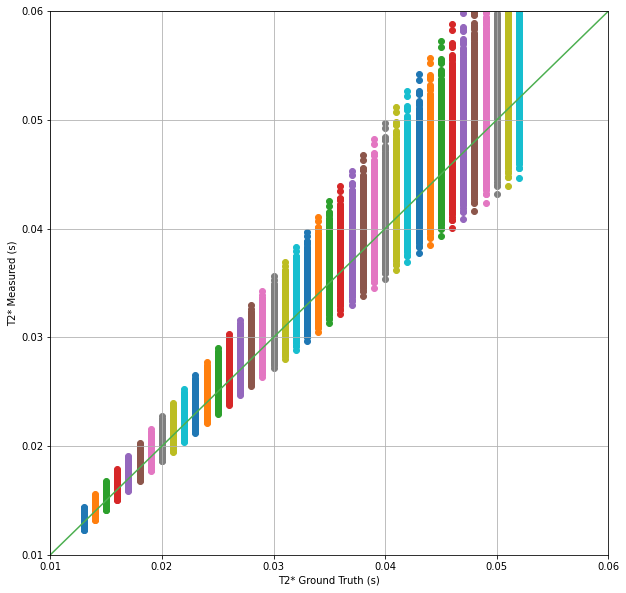

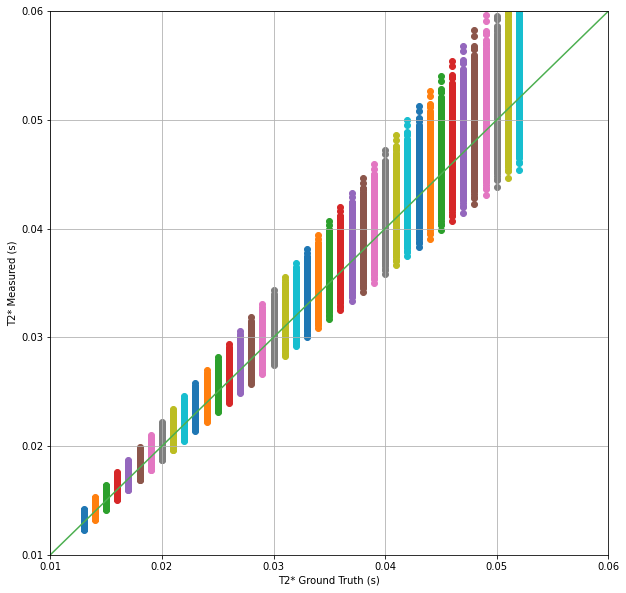

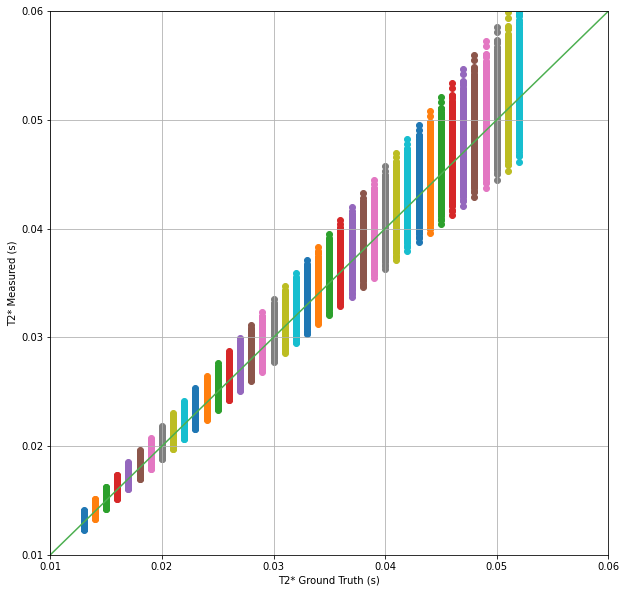

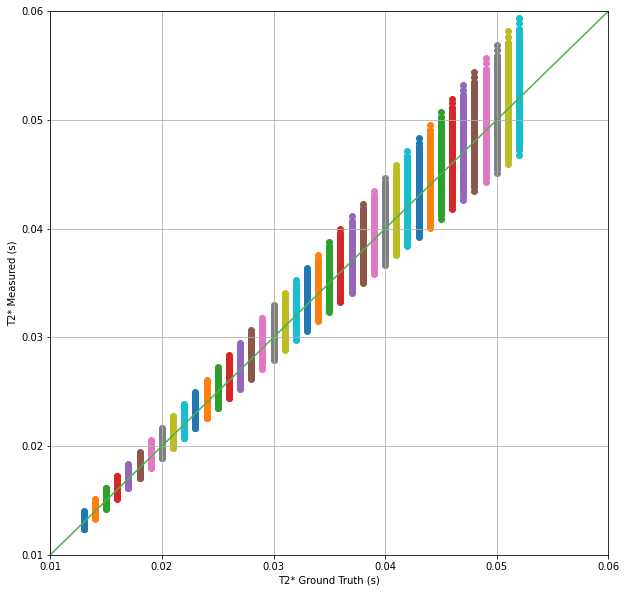

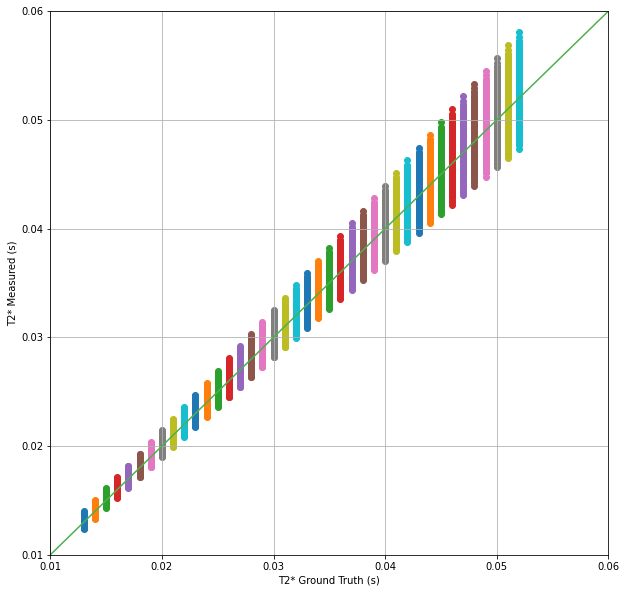

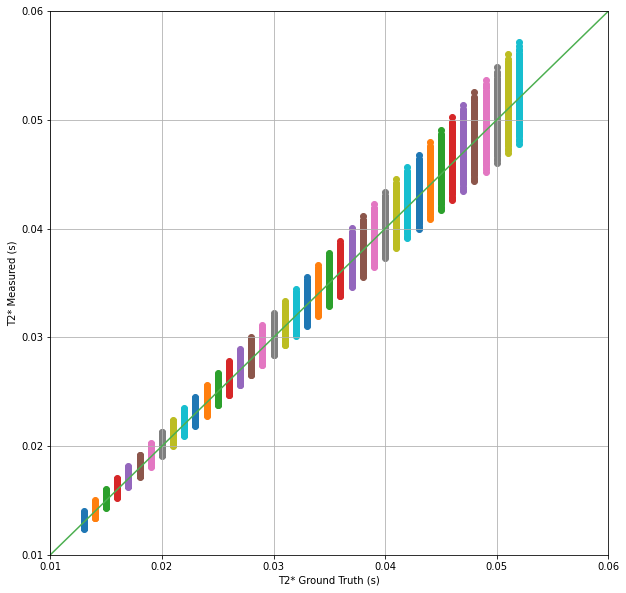

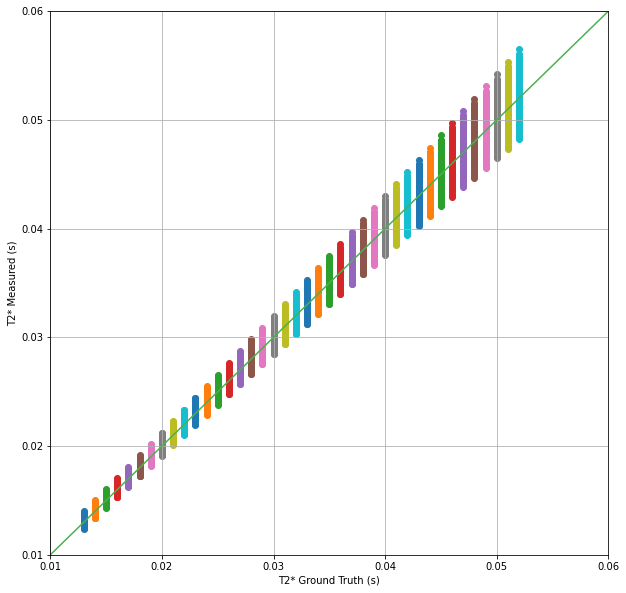

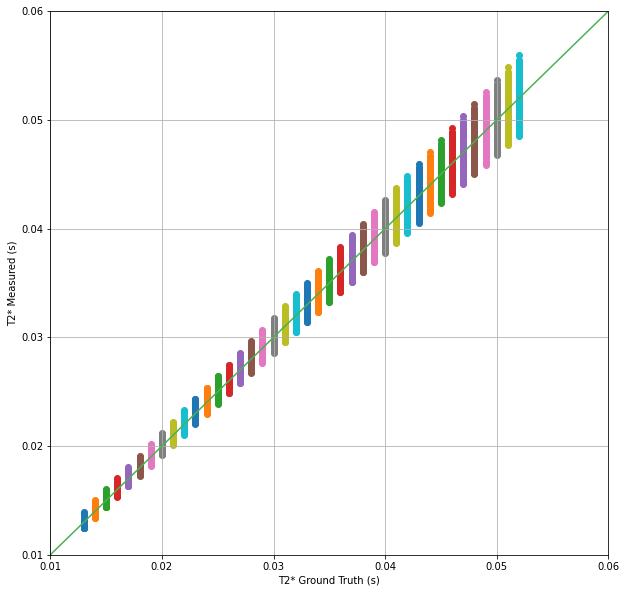

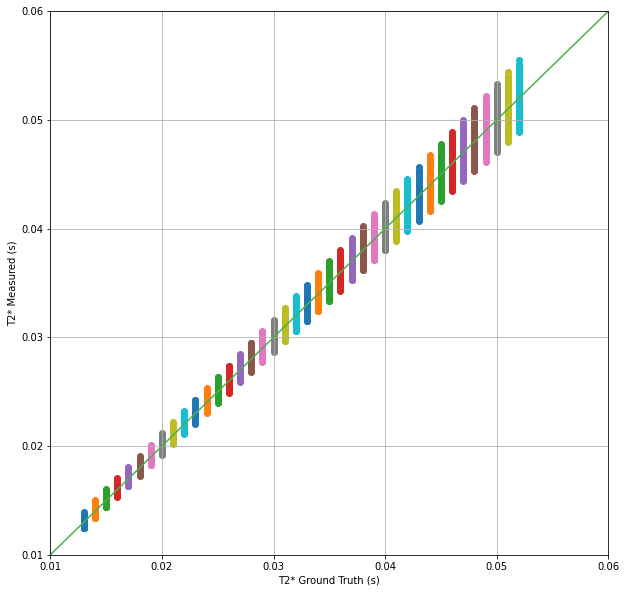

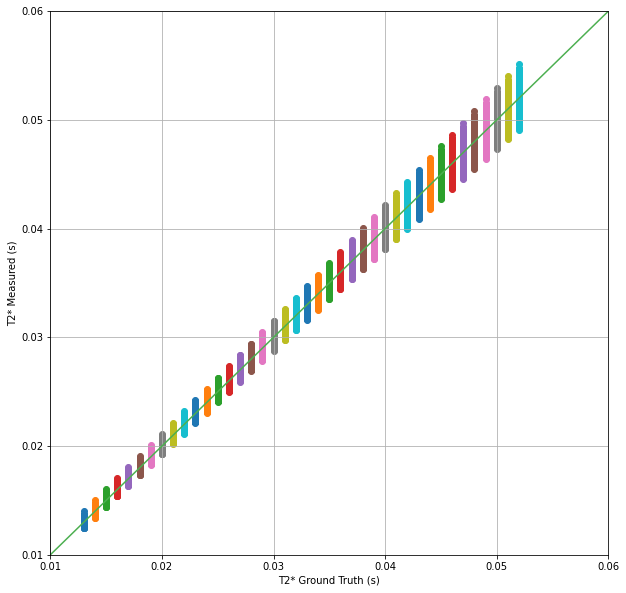

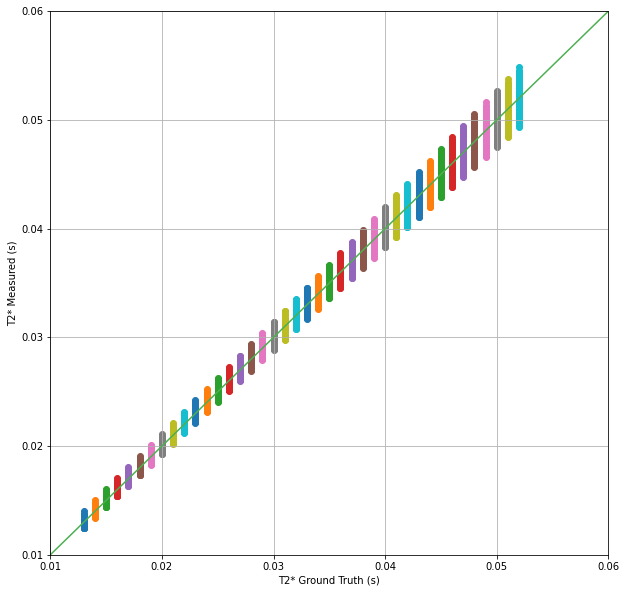

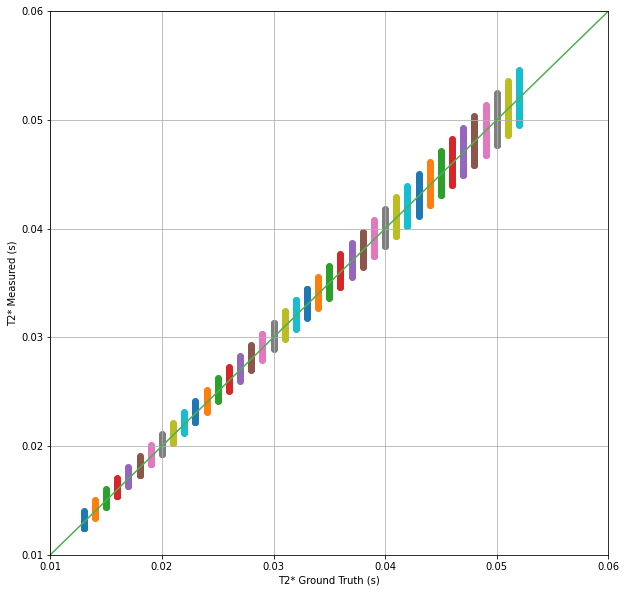

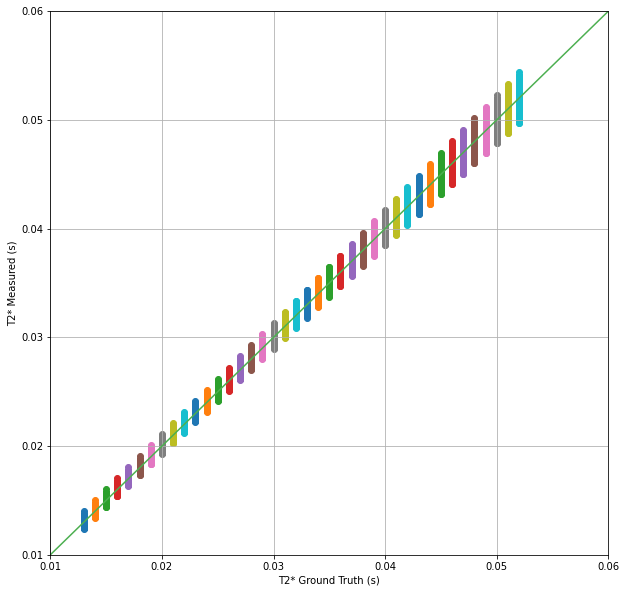

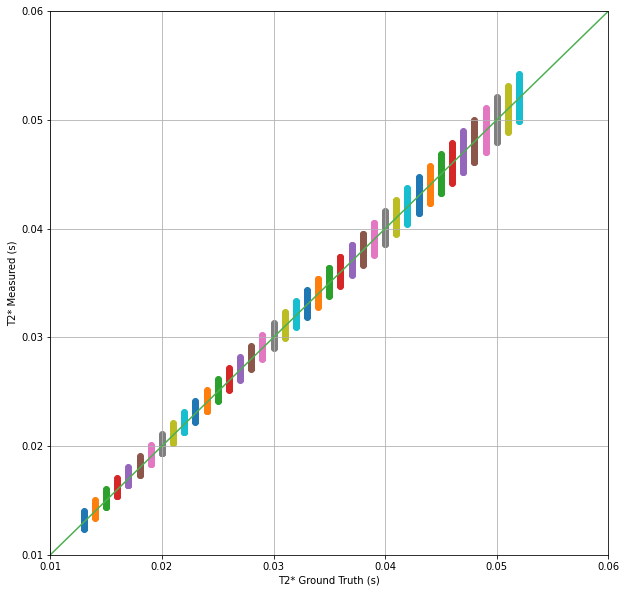

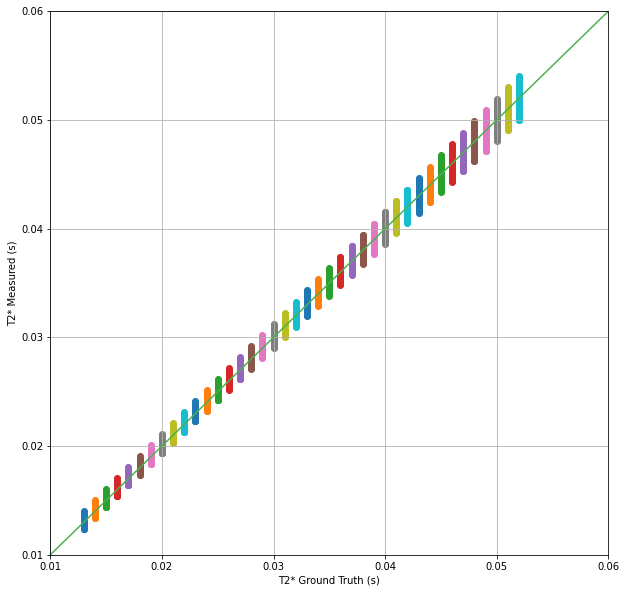

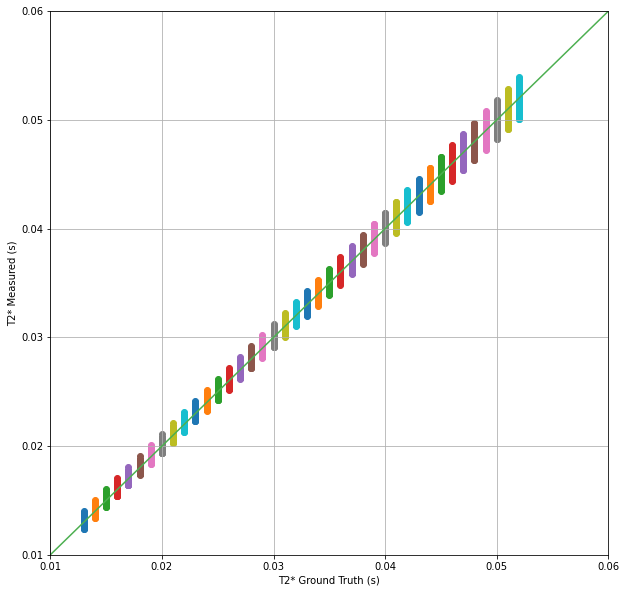

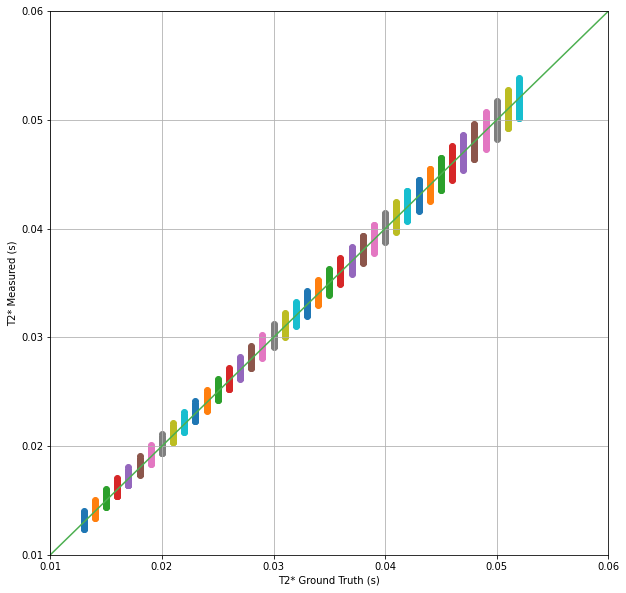

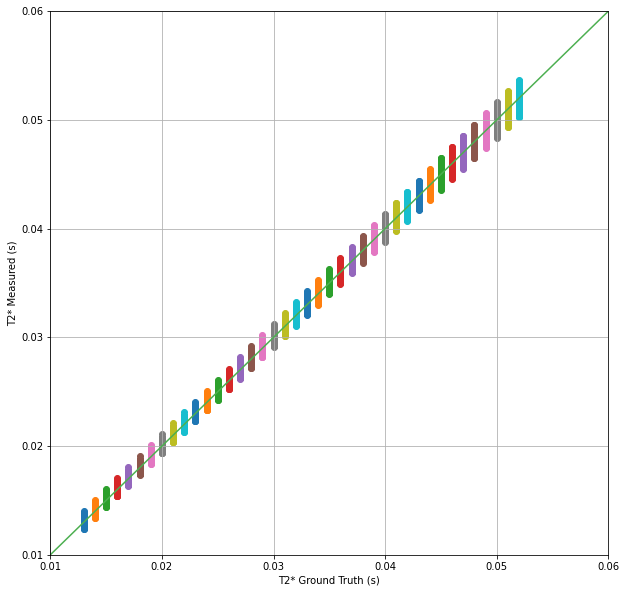

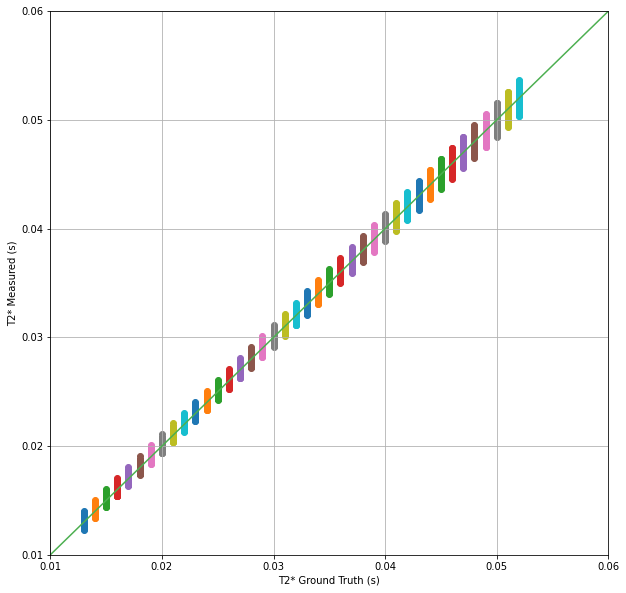

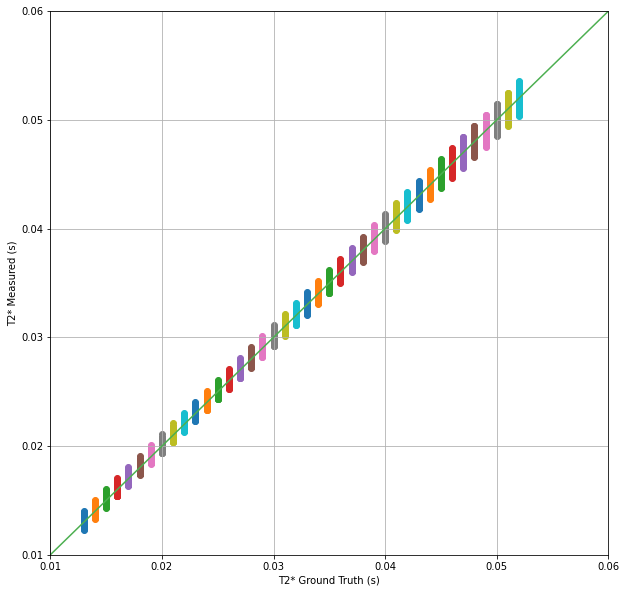

In [19]:
for i in range (0,20):
    tr = TR[i]
    d = np.load("EightPeriodData_"+str(tr)+"_0.01Noise.npy")
    figurex = DrawT2StarGraph(d, T2Star_GT, Period, TR[i])

# Visualise the RF spoiling phase angle

0.0
25.714285714285715
102.85714285714286
231.42857142857142
51.428571428571445
282.8571428571429
205.71428571428567


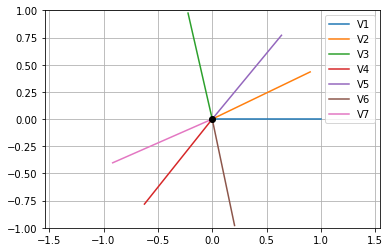

In [57]:
#Visualise the RF quadratic spoiling angle
Period = 7

fig = plt.figure()
ax = fig.add_subplot(1,1,1)
V = np.asarray([[0,0]], dtype = float)
for i in range (0,Period):
    p = QuadraticPhase(Period,i)
    phaseshift_rad = np.radians(p-(p//360))
    tmp = p 
    tmp = tmp % 360
    print(tmp)
    #line_1 = plt.Line2D([0,math.cos(phaseshift_rad)], [0,math.sin(phaseshift_rad)], linewidth=1, linestyle = "-", label = i)
    #ax.add_line(line_1)

    V = np.append(V,[[math.cos(phaseshift_rad),math.sin(phaseshift_rad)]], axis =0)
    

V = np.delete(V, 0,0)
# origin = np.array(np.zeros((2,Period))) # origin point
# plt.quiver(*origin, V[:,0], V[:,1], scale=5)
# plt.show()

# ax.set(xlim=[-1,1])
# ax.set(ylim=[-1,1])
#print(V)

rows,cols =V.T.shape

#Get absolute maxes for axis ranges to center origin
#This is optional
maxes = 1.1*np.amax(abs(V), axis = 0)

for i,l in enumerate(range(0,cols)):
    xs = [0,V[i,0]]
    ys = [0,V[i,1]]
    plt.plot(xs,ys)

plt.plot(0,0,'ok') #<-- plot a black point at the origin
plt.axis('equal')  #<-- set the axes to the same scale
plt.xlim([-1,1]) #<-- set the x axis limits
plt.ylim([-1,1]) #<-- set the y axis limits
plt.legend(['V'+str(i+1) for i in range(cols)]) #<-- give a legend
plt.grid(True) #<-- plot grid lines
plt.show()

0.04638441531691883


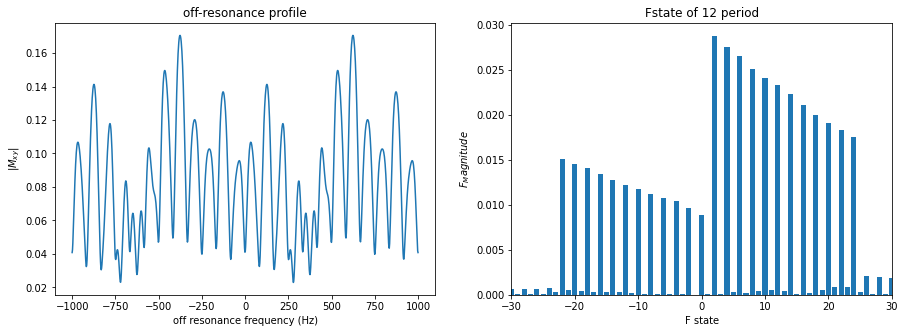

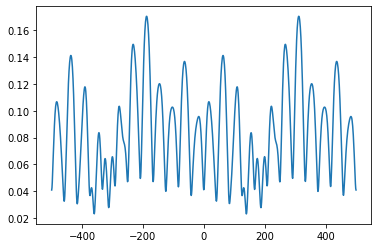

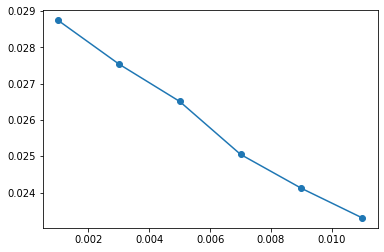

In [24]:
#Check off-resonance profile------------------------------------------------------------------------
TR_list = [2]* Nr
TE = 1e-3
#number of sample point in off-resonance profile
off_resonance_f, M_transverse =  blochc(off_res, off_res_samplesize, M0 = M0 , alpha = alpha, phi = phi, dphi = dphi, TR= TR_list, TE= TE*1e3, T1 = T1*1e3, T2 = T2*1e3)


#Check current F-State look like---------------------------------------------------------------------
fig, ax = Offres_Fstate_plot(off_resonance_f, np.transpose(M_transverse), 1, Period, -30, 30)
plt.figure(2)
plt.plot(off_resonance_f/2, np.abs(M_transverse))

#Check T2* fit
F_state_magnitude, F_state = Fstate(np.transpose(M_transverse))
#fit using 6 or less F-states
F_state = np.round(F_state).astype(int) #round F-state all to integer 
F = np.asarray([], dtype = float)
F_Magnitude = np.asarray([], dtype = float)
if (Period >=6):
    for i in range (0,6):
        F_index = np.where(F_state == float(2+2*i))

        F = np.append(F, i)
        F_Magnitude = np.append(F_Magnitude, np.abs(F_state_magnitude[0,F_index]))

    #End
else:
    for i in range (0,Period):
        F_index = np.where(F_state == float(2+2*i))

        F = np.append(F, i)
        F_Magnitude = np.append(F_Magnitude, np.abs(F_state_magnitude[0,F_index]))

    #End

## time = TE+F*TR
time = TE*np.ones(np.shape(F))+ F *TR[0]

def func(t, A, R2Star):
    return A * np.exp(-R2Star * t)
#fitted coefficient stored in popt:[A R2*] --> T2* = 1/R2*
popt, pcov = curve_fit(func, time, F_Magnitude)

plt.figure(3)
plt.plot(time, F_Magnitude, marker = 'o')
T2Star_measured = 1/popt[1]
print(T2Star_measured)

## 